## Importing dependencies

### First Party

Importing custom classes from the codebase:
- **dataset**: helper _torch_ wrapper around _facades_ dataset.
- **pix2pix**: implementation of _Pix2Pix_ architecture. Both generator and discriminator and the corresponding loss functions.

### Third Party

- **opencv**: image processing library, helps to load/save images.
- **numpy**: nd arrays utilities, includes math and arithmetics.
- **torch**: ML framework, extremelly friendly to GPU, the network architecture was specifically designed in torch.
- **torchvision**: set of image transformations, like crop and flip. It is important to use _v2_ transforms as it can apply the same transformations to image and corresponding segmentation labels where stochastic operations used. 
- **matplotlib**: library to visualise data.
- **tqdm**: visualises progress.

In [1]:
# 3rd Party dependencies.
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as transforms

from torch.utils.data import DataLoader
from tqdm import tqdm

# 1st Party dependencies.
from dataset.facades_dataset import FacadesDataset
from pix2pix.generator import Generator, GeneratorLoss
from pix2pix.discriminator import Discriminator, DiscriminatorLoss

%matplotlib inline

## Pre-processing data

I decided to apply the transformations described in [the original paper](https://arxiv.org/abs/1611.07004) (see paragraph 6.2 for more details): resize to _286×286_, random crop, and apply random mirroring.

In [2]:
# Default transforms are noted in the original paper
# in paragraph 6.2 as "Random jitter".
# The experiment is called "Cityscapes labels→photo".
train_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    # Resizing the 256×256 input images to 286×286.
    transforms.Resize((286, 286)), 
    # Randomly cropping back to size 256×256.
    transforms.RandomCrop(256),
    # Mirroring.
    transforms.RandomHorizontalFlip(),
])

default_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

## Loading dataset

- **train**: I will use this dataset for training the model. Train dataset uses special transformations.
- **val**: there is no need to use validation dataset as training generator is mostly unsupervised. Though, maybe it makes sense to test discriminator generalisation ability, I don't find it useful in the current setting. I am using _val_ split to just visually check _generator_ ability. Val does not use any transformation.

In [3]:
facades_train_dataset = FacadesDataset(root_dir='dataset/facades', split='train', transformations=train_transforms)
facades_val_dataset = FacadesDataset(root_dir='dataset/facades', split='val', transformations=default_transforms)

train_dataloader = DataLoader(facades_train_dataset, batch_size=1, shuffle=True)

Visualising _train dataset_ to check that the transformations are applied the same way to the real image and the condition (facade segmentation).

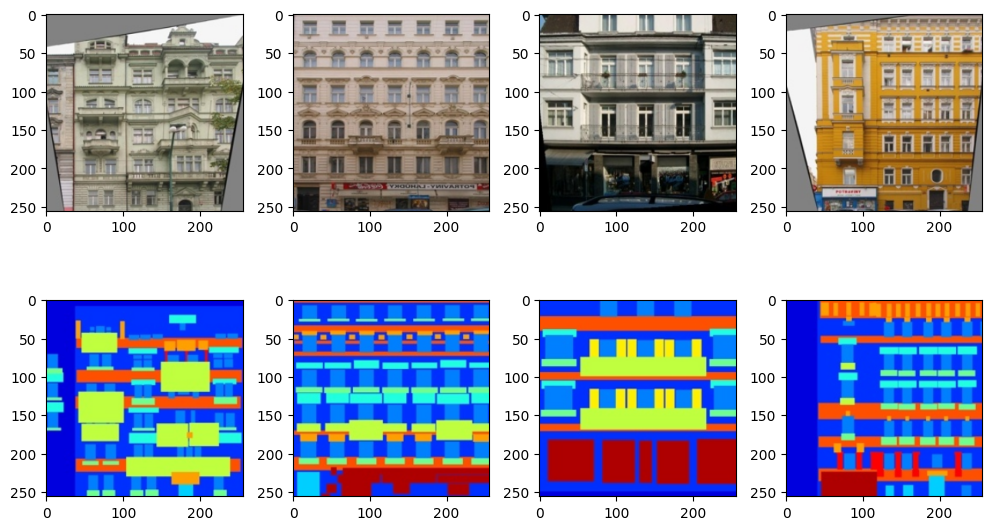

In [4]:
def visualise_dataset(dataset, indexes):
    figure, ax = plt.subplots(nrows=2, ncols=len(indexes), figsize=(10, 6))
    
    for i, idx in enumerate(indexes):
        image, label = dataset[idx]
        image = np.transpose(image.numpy(), (1,2,0))
        label = np.transpose(label.numpy(), (1,2,0))
        
        ax[0, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[1, i].imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
    plt.tight_layout(pad=1)
    plt.show()    

visualise_dataset(facades_train_dataset, np.random.choice(range(len(facades_train_dataset)), 4))

## Running the training cycle

In the original paper they trained the model for _200 epochs_. Initially, I run the model in the same setting.
Though, it seems that generator can learn slightly more and produce more plausible _fakes_. I will try to train the model for _400 epochs_ and see whether 200th epoch checkpoint is different from 400th epoch.

In [5]:
# Setup.
device = ('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 3 * 1e-4
epochs = 400

print('Starting training:', device, 'was selected for training')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

generator_loss = GeneratorLoss(alpha=100)
discriminator_loss = DiscriminatorLoss()

generator_history = []
discriminator_history = []

for epoch in range(epochs):

    generator_losses = []
    discriminator_losses = []

    for real, condition in tqdm(train_dataloader):        
        condition = condition.to(device)
        real = real.to(device)

        # Generator's loss.
        fake = generator(condition)
        fake_pred = discriminator(fake, condition)
        gl = generator_loss(fake, real, fake_pred)

        # Discriminator's loss.
        fake = generator(condition).detach()
        fake_pred = discriminator(fake, condition)
        real_pred = discriminator(real, condition)
        dl = discriminator_loss(fake_pred, real_pred)

        generator_optimizer.zero_grad()
        gl.backward()
        generator_optimizer.step()

        discriminator_optimizer.zero_grad()
        dl.backward()
        discriminator_optimizer.step()

        generator_losses.append(gl.item())
        discriminator_losses.append(dl.item())

    epoch_g_loss = np.mean(generator_losses)
    epoch_d_loss = np.mean(discriminator_losses)
    
    generator_history.append(epoch_g_loss)
    discriminator_history.append(epoch_d_loss)

    print('Epoch:', epoch, 'generator loss:', epoch_g_loss, 'discriminator loss:', epoch_d_loss)

    weights_dir = os.path.join('out', 'weights', 'pix2pix')
    os.makedirs(weights_dir, exist_ok=True)

    torch.save(generator.state_dict(), os.path.join(weights_dir, f"generator-{epoch:03d}-{epoch_g_loss:.3f}.pt"))
    torch.save(discriminator.state_dict(), os.path.join(weights_dir, f"discriminator-{epoch:03d}-{epoch_g_loss:.3f}.pt"))

Starting training cuda was selected for training


100%|█████████████████████████████████████████████████████████████████████████████████| 400/400 [01:31<00:00,  4.37it/s]


Epoch: 0 generator loss: 24.429514210224152 discriminator loss: 0.1566531291694264


NameError: name 'os' is not defined

## Visualising training history

- Generator: it seems that generator sucessfully reduces the distance between generated fakes and real images. It seems that training the model longer was a step in the right direction. 
- Discriminator: training is really unstable and it not clear whether it learns something. Though the overall quality seems good.

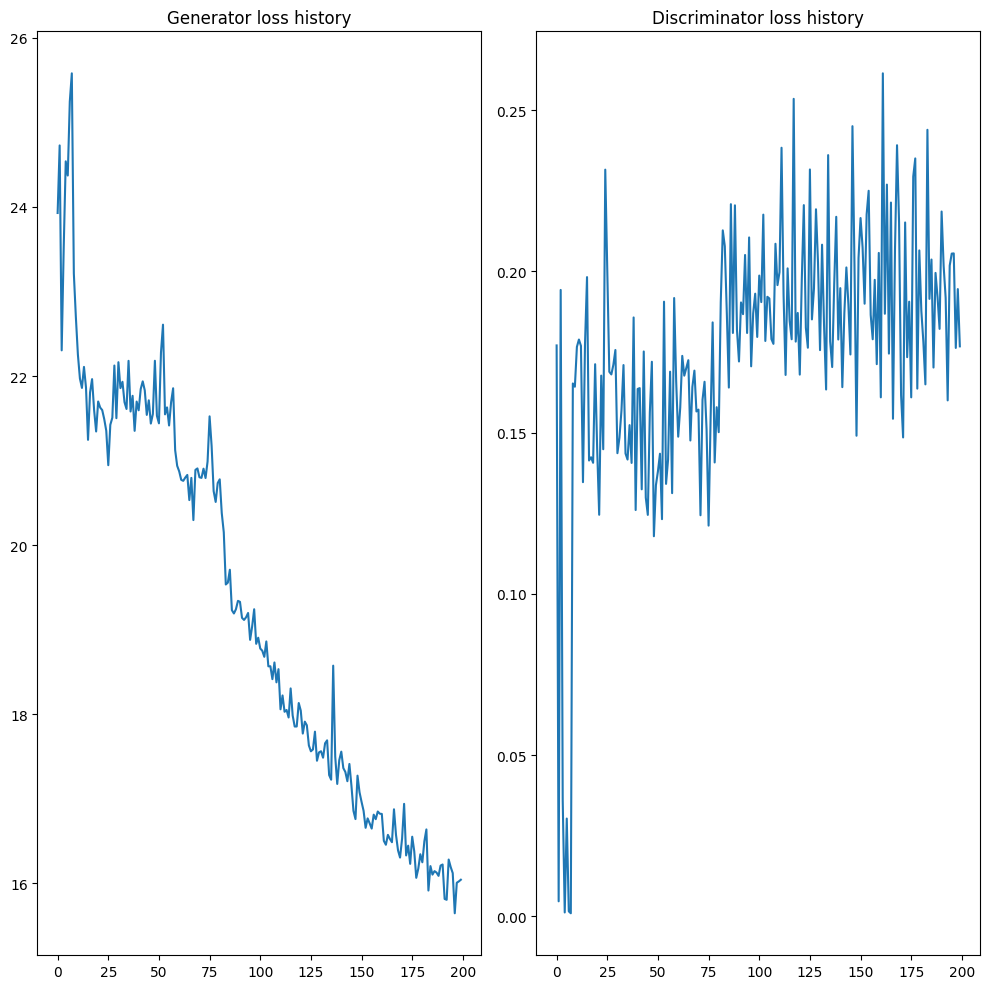

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].set_title("Generator loss history")
ax[0].plot(generator_history)

ax[1].set_title("Discriminator loss history")
ax[1].plot(discriminator_history)

plt.tight_layout()
plt.show()

Let's visualise _200th epoch_ vs. _400th epoch_

- _200th epoch_
- _400th epoch_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


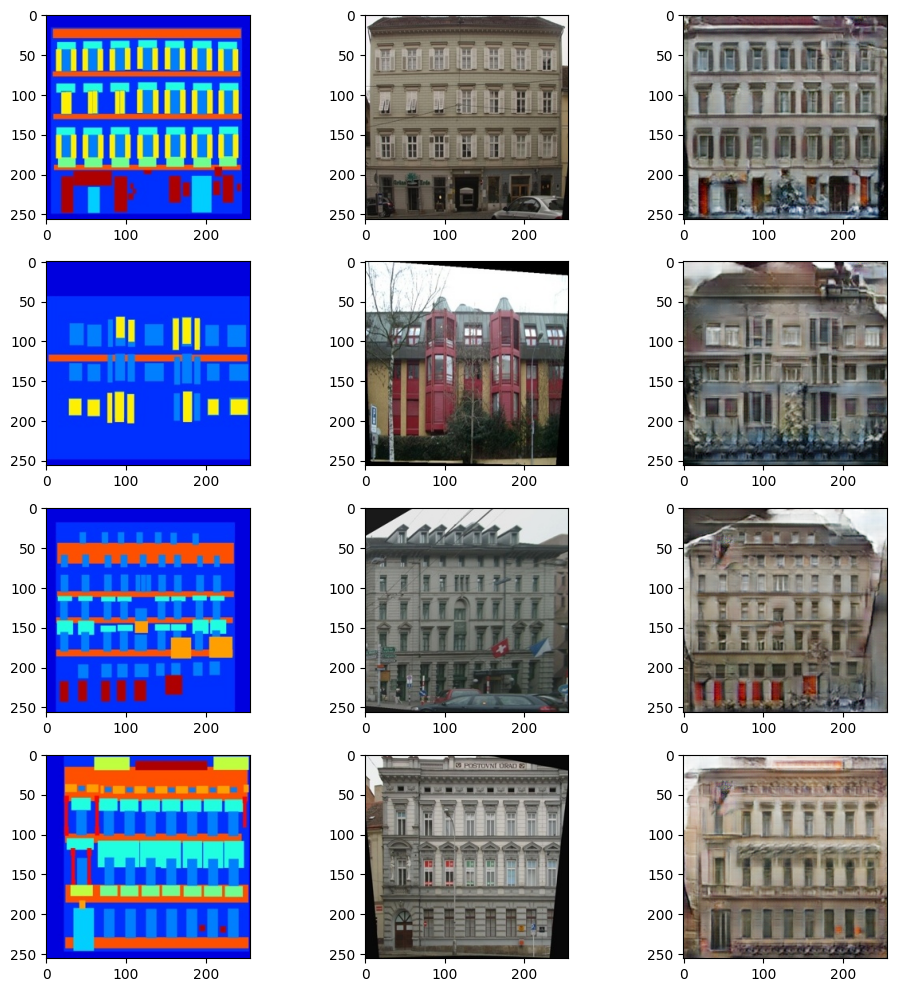

In [41]:
def visualise_inference(model_file, dataset, indexes):
    generator_model = UnetGenerator().to(device)
    generator_model.load_state_dict(torch.load(model_file))
    
    figure, axes = plt.subplots(nrows=len(indexes), ncols=3, figsize=(10, 10))
    
    for i, idx in enumerate(indexes):
        image, label = dataset[idx]

        input = torch.tensor(np.expand_dims(label, 0))
        fake = generator_model(input)
        fake = fake.detach().numpy()

        fake = np.transpose(fake[0], (1,2,0))
        image = np.transpose(image.numpy(), (1,2,0))
        label = np.transpose(label.numpy(), (1,2,0))

        axes[i, 0].imshow(cv2.cvtColor(label, cv2.COLOR_BGR2RGB))
        axes[i, 1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[i, 2].imshow(cv2.cvtColor(fake, cv2.COLOR_BGR2RGB))

    for i, ax in enumerate(axes.flatten()[:2]):
        ax.axis("off")
        ax.set_title("Columntitle {}".format(i+1), fontweight='bold')

    fig.subplots_adjust(hspace=0.5, bottom=0.1)
    plt.tight_layout(pad=1)
    plt.show()    

In [ ]:
validation_samples = np.random.choice(range(len(facades_val_dataset)), 6)

In [ ]:
visualise_inference('generator-197-16.008.pt', facades_val_dataset, validation_samples)

In [ ]:
visualise_inference('generator-197-16.008.pt', facades_val_dataset, validation_samples)